In [36]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [37]:
from fastbook import *
from fastai.vision.widgets import *
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

In [38]:
key = os.environ.get('AZURE_SEARCH_KEY', '4aaa914e1fd44a00872a403ffa466af5')

In [46]:
results = search_images_bing(key, 'angry face')
ims = results.attrgot('contentUrl')
len(ims)

150

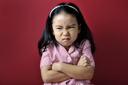

In [48]:
dest = 'images/angry.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

1. Download images

In [67]:
face_types = 'angry','happy','neutral',"sad","frustrated"
path = Path('faces')

In [55]:
if not path.exists():
    path.mkdir()
    for o in face_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} face')
        download_images(dest, urls=results.attrgot('contentUrl'))

IndentationError: unexpected indent (<ipython-input-55-f9fcd65a34c9>, line 3)

In [68]:
for o in face_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} face')
        download_images(dest, urls=results.attrgot('contentUrl'))

2. Verify images

In [69]:
fns = get_image_files(path)
fns

(#697) [Path('faces/sad/00000055.jpg'),Path('faces/sad/00000085.png'),Path('faces/sad/00000036.jpg'),Path('faces/sad/00000097.jpg'),Path('faces/sad/00000110.jpg'),Path('faces/sad/00000029.jpg'),Path('faces/sad/00000112.jpg'),Path('faces/sad/00000091.jpg'),Path('faces/sad/00000090.jpg'),Path('faces/sad/00000147.jpg')...]

In [70]:
failed = verify_images(fns)
failed.map(Path.unlink);

3. To DataLoader

In [71]:
my_class = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [72]:
dls = my_class.dataloaders(path)

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


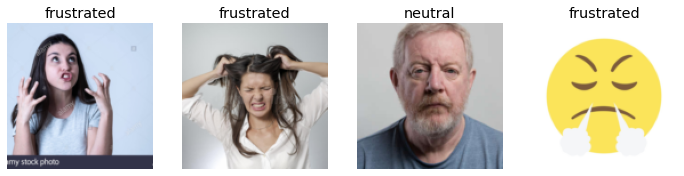

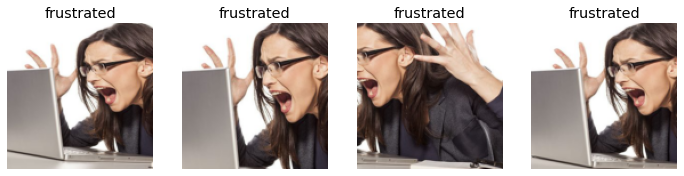

In [73]:
dls.valid.show_batch(max_n=4, nrows=1)
my_class = my_class.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = my_class.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

4. Train model

In [74]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.523896,1.974488,0.583942,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.639220,1.202103,0.408759,00:07
1,1.512873,1.086524,0.357664,00:08
2,1.309991,0.950999,0.291971,00:08
3,1.225643,0.913565,0.299270,00:07


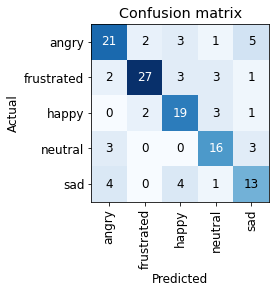

In [75]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

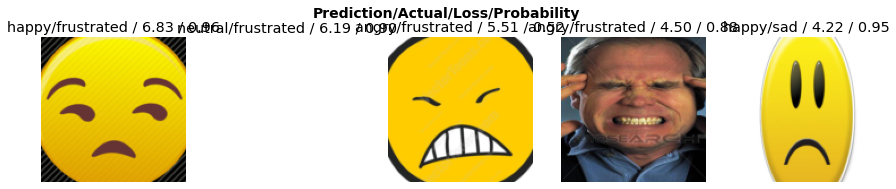

In [76]:
interp.plot_top_losses(5, nrows=1)

5. Clean data

In [77]:
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: [Errno 2] No such file or directory: '/notebooks/faces/frustrated/00000136.png'

In [79]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [80]:
learn.export()

In [81]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [82]:
learn_inf = load_learner(path/'export.pkl')

In [83]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [84]:
img = PILImage.create(btn_upload.data[-1])


In [85]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [86]:
pred,pred_idx,probs = learn_inf.predict(img)

In [87]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: neutral; Probability: 0.9637')

In [88]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [89]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)